In [1]:
__author__ = 'siying'

%matplotlib inline

import ast
import json
import urllib
import urllib2
import pylab as plt
import os
import statsmodels.formula.api as smf
import pysal
from cStringIO import StringIO
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import mplleaflet
s = json.load( open(os.getenv('PUI2015')+'/fbb_matplotlibrc.json') )
SQL_SOURCE = 'https://htv210.cartodb.com/api/v2/sql'

In [2]:
def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [3]:
dischargeQuery = '''
SELECT facility_id, COUNT(*) AS count
FROM nyc_discharge_2013
WHERE lower(ccs_diagnosis_description) LIKE '%asthma%'
GROUP BY facility_id
ORDER BY count DESC
LIMIT 5
'''

## Task 1

In [4]:
# dischargeStream = queryCartoDB(dischargeQuery, format='CSV')
# discharge       = pd.read_csv(dischargeStream)

# facilityStream = queryCartoDB(facilityQuery, format='GeoJSON')
# facilityData   = json.loads(facilityStream.read())
# facilities     = gpd.GeoDataFrame.from_features(facilityData['features'])

# zipcodeStream = queryCartoDB(zipcodeQuery, format='GeoJSON')
# zipcodeData   = json.loads(zipcodeStream.read())
# zipcodes      = gpd.GeoDataFrame.from_features(zipcodeData['features'])

facilityStream = queryCartoDB(dischargeQuery, format='CSV')
facilities = pd.read_csv(facilityStream)

In [5]:
facilities.head()

,facility_id,count
0,1172,1878
1,1169,1786
2,1301,1057
3,1165,920
4,1178,890


In [6]:
facID = str(tuple(facilities.facility_id.tolist()))

In [7]:
facilityQuery = '''
SELECT *
FROM nyc_facilities
WHERE facility_id in %s
''' % facID

In [8]:
facilityStream = queryCartoDB(facilityQuery, format='GeoJSON')
facilityData   = json.loads(facilityStream.read())
all_facilities   = gpd.GeoDataFrame.from_features(facilityData['features'])

In [9]:
# all_facilities = facilities[['facility_id','facility_name']]
all_facilities.head()

,cartodb_id,cooperator_address,cooperator_address_2,cooperator_city,cooperator_name,cooperator_state,cooperator_zip_code,description,facility_address_1,facility_address_2,...,operator_address_1,operator_address_2,operator_city,operator_name,operator_state,operator_zip_code,ownership_type,regional_office,regional_office_id,short_description
0,624,,,,,New York,NaN,Hospital,1400 Pelham Parkway,,...,125 Worth Street,,New York,New York City Health and Hospital Corporation,New York,10013,Municipality,Metropolitan Area Regional Office - New York City,5,HOSP
1,627,111 East 210th Street,,Bronx,Montefiore Medical Center,New York,10467,Hospital,111 East 210th Street,,...,111 East 210th Street,,Bronx,"Montefiore Health System, Inc",New York,10467,Not for Profit Corporation,Metropolitan Area Regional Office - New York City,5,HOSP
2,628,,,,,New York,NaN,Hospital,234 East 149th Street,,...,125 Worth Street,,New York,New York City Health and Hospital Corporation,New York,10013,Municipality,Metropolitan Area Regional Office - New York City,5,HOSP
3,631,,,,,New York,NaN,Hospital,1650 Grand Concourse,,...,1276 Fulton Avenue,,Bronx,Bronx Lebanon Hospital Center Inc,New York,10456,Not for Profit Corporation,Metropolitan Area Regional Office - New York City,5,HOSP
4,696,,,,,New York,NaN,Hospital,451 Clarkson Avenue,,...,125 Worth Street,,New York,New York City Health and Hospital Corporation,New York,10013,Municipality,Metropolitan Area Regional Office - New York City,5,HOSP


In [11]:
zips = gpd.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
all_facilities.crs = {'init':'epsg:4326', 'no_defs':True}
all_facilities.to_crs(zips.crs, inplace=1)

In [12]:
ax=all_facilities.plot()
mplleaflet.display(fig=ax.figure, crs=zips.crs, tiles='cartodb_positron')

## Task 2

In [13]:
zipcodes = str(tuple(all_facilities.facility_zip_code.tolist()))
zipcodes

'(10461, 10467, 10451, 10457, 11203)'

In [14]:
select_highwayQuery = '''
SELECT *
FROM nyc_zipcode_highway
WHERE zipcode in %s
''' % zipcodes

all_highwayQuery = '''
SELECT *
FROM nyc_zipcode_highway
'''

In [15]:
top5zipStream = queryCartoDB(query=select_highwayQuery, format='GeoJSON')
top5zipdata = json.loads(top5zipStream.read())
top5zips = gpd.GeoDataFrame.from_features(top5zipdata['features'])

* answer for T2, part 1

In [16]:
top5zips

,cartodb_id,geometry,highway_length,zipcode
0,106,"(POLYGON ((-73.863293 40.89529, -73.862875 40....",19.172015,10467
1,111,"(POLYGON ((-73.931681 40.807955, -73.931704 40...",7.914185,10451
2,123,"(POLYGON ((-73.897516 40.856183, -73.896533000...",5.017199,10457
3,125,"(POLYGON ((-73.82612399999999 40.834214, -73.8...",18.102258,10461
4,195,"(POLYGON ((-73.942503 40.638965, -73.943986 40...",2.212840,11203


In [17]:
ziphighStream = queryCartoDB(query=all_highwayQuery, format='GeoJSON')
ziphighdata = json.loads(ziphighStream.read())
ziphigh= gpd.GeoDataFrame.from_features(ziphighdata['features'])

In [18]:
top5zips.crs= {'init':'epsg:4326', 'no_defs':True}
ziphigh.crs={'init':'epsg:4326', 'no_defs':True}
top5zips.to_crs(zips.crs, inplace=1)
ziphigh.to_crs(zips.crs, inplace=1)

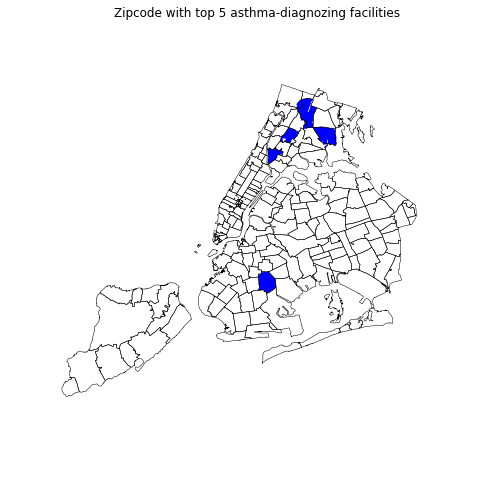

In [19]:
fig,ax = plt.subplots(figsize=(8,8))
top5zips.plot(ax=ax,alpha=1,color='b',linewidth=0)
zips.plot(ax=ax,alpha=0,linewidth=0.5)
ax.set_axis_off()
ax.set_title('Zipcode with top 5 asthma-diagnozing facilities')

<bound method AxesSubplot.set_axis_off of <matplotlib.axes._subplots.AxesSubplot object at 0x10e7734d0>>

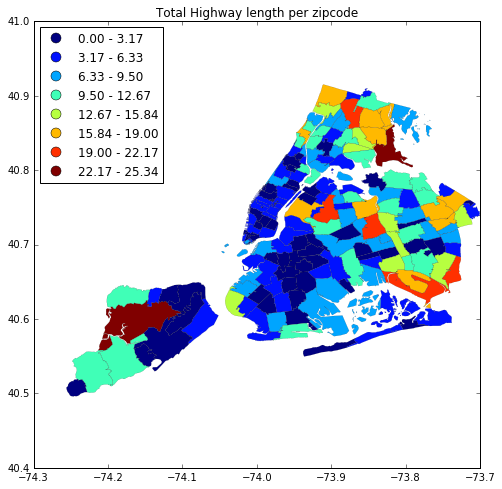

In [20]:
f, ax = plt.subplots(figsize=(8,8))

ziphigh.plot(column='highway_length',linewidth=0.1,ax=ax,scheme='equal_interval',alpha=1,legend=True,k=8)
ax.set_title('Total Highway length per zipcode')
ax.set_axis_off

## Task 5

#### NOTICE: this dataset takes a few minutes

In [23]:
source = 'http://data.cityofnewyork.us/api/views/3rfa-3xsf/rows.csv?accessType=DOWNLOAD'

In [24]:
call311 = pd.read_csv(source, header=0)

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (8,13,14,17,18,20,37,38,39,40,41,42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#col=asthma311.columns
#idx = asthma311['Incident Zip'].values
# asthma = pd.DataFrame(asthma311,index=idx)

In [25]:
call311 = call311[['Unique Key','Complaint Type','Location Type','Incident Zip','Latitude','Longitude','Location']]

you can aggregate the 311 calls at the zip code level directly (the zip code is available in the 311 calls data for every call).
some of the 311 calls may be directly related to asthma cases: complaints about construction, unsanitary conditions, mold, while others may not (illegally parked cars for example). This is a list of call descriptions which we considered relevant. You can modify this list as you see fit. But you must justify your choice of relevant complaints.

Because complaints to 311 are issued at a different rate in different city areas (due to various reasons including a strong social bias by which wealthier people are generally more engaged and more likely to call) you must normalize the number of relevant calls (calls for one of the reasons in your list) by the total number of calls for that zip code (divide the number of relevant calls by the total number of calls) (normalize = divide)

In [26]:
# normalize 311data (divide #relevant calls by the total #calls)
totalcallZip = call311['Incident Zip'].value_counts()
totalZip = totalcallZip.reset_index().rename(columns={'Incident Zip':'Total calls'})

In [27]:
totalZip.head()

,index,Total calls
0,11226,27141
1,10458,22147
2,10467,22088
3,10457,20099
4,11207,20092


In [28]:
conditions = ['UNSANITARY CONDITION','Dirty Conditions', 'Sewer',
               'Hazardous Material','Construction',
               'Indoor Air Quality','Indoor Sewage','Air Quality',
               'HEATING','Industrial Waste','Mold','Asbestos',
               'Sweeping/Missed-Inadequate','Smoking',
               'Non-Residential Heat','Lead','Standing Water',
                'Water Quality','Unsanitary Animal Facility',
               'PAINT - PLASTER ','GENERAL CONSTRUCTION',
             ]

In [29]:
asthma311 = call311[call311['Complaint Type'].isin(conditions)]

In [30]:
asthmacallZip = asthma311['Incident Zip'].value_counts()
asthmaZip = asthmacallZip.reset_index().rename(columns={'Incident Zip':'Total calls'})

In [31]:
asthmaZip.head()

,index,Total calls
0,11226,10116
1,10458,9373
2,10467,8255
3,10453,8066
4,10457,7972


In [32]:
asthma = totalZip.merge(asthmaZip,how='left',on='index')

In [33]:
asthma.columns=['zipcode','totalCall','asthmaCall']
asthma.head()

,zipcode,totalCall,asthmaCall
0,11226,27141,10116
1,10458,22147,9373
2,10467,22088,8255
3,10457,20099,7972
4,11207,20092,5618


In [34]:
# normalize the data
asthma['asthNorm'] = asthma.asthmaCall/asthma.totalCall
asthma.head()

,zipcode,totalCall,asthmaCall,asthNorm
0,11226,27141,10116,0.372720
1,10458,22147,9373,0.423218
2,10467,22088,8255,0.373732
3,10457,20099,7972,0.396637
4,11207,20092,5618,0.279614


In [35]:
top5zips_new = top5zips.merge(asthma[['zipcode','asthNorm']],how='left',on='zipcode')
top5zips_new.head()

,cartodb_id,geometry,highway_length,zipcode,asthNorm
0,106,"(POLYGON ((-73.863293 40.89529, -73.862875 40....",19.172015,10467,0.522590
1,111,"(POLYGON ((-73.931681 40.807955, -73.931704 40...",7.914185,10451,0.505349
2,123,"(POLYGON ((-73.897516 40.85618300000001, -73.8...",5.017199,10457,0.506032
3,125,"(POLYGON ((-73.82612399999999 40.834214, -73.8...",18.102258,10461,0.417339
4,195,"(POLYGON ((-73.942503 40.638965, -73.943986 40...",2.212840,11203,0.459787


In [36]:
ziphigh_new = ziphigh.merge(asthma[['zipcode','asthNorm']],how='left',on='zipcode')
ziphigh_new.fillna(0,inplace=1)
ziphigh_new.head()

,cartodb_id,geometry,highway_length,zipcode,asthNorm
0,1,"(POLYGON ((-74.194287 40.608911, -74.194929 40...",23.486470,10314,0.138223
1,2,"(POLYGON ((-73.980886 40.75927, -73.9804259999...",0.000000,10112,0.000000
2,3,"(POLYGON ((-74.011674 40.709687, -74.012646 40...",1.447405,10048,0.000000
3,4,"(POLYGON ((-73.97282 40.75587, -73.973276 40.7...",0.000000,10171,0.000000
4,5,"(POLYGON ((-73.973735 40.754619, -73.975352 40...",0.000000,10172,0.000000


In [37]:
ziphigh_new.crs = {'init': 'epsg:4326', 'no_defs': True}
ziphigh_new.to_crs(zips.crs, inplace=1)

<bound method AxesSubplot.set_axis_off of <matplotlib.axes._subplots.AxesSubplot object at 0x142615a50>>

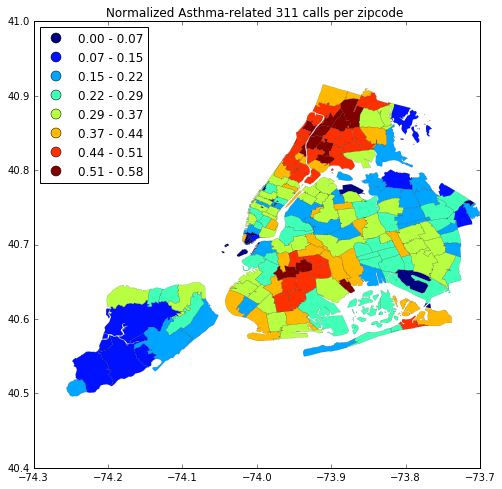

In [38]:
f, ax = plt.subplots(figsize=(8,8))

ziphigh_new.plot(column='asthNorm',linewidth=0.1,ax=ax,alpha=1,legend=True,k=8,scheme='equal_interval')
ax.set_title('Normalized Asthma-related 311 calls per zipcode ')
ax.set_axis_off

## Task 6

In [39]:
allfac = all_facilities.merge(facilities, how='left', on='facility_id').rename(columns={'facility_zip_code':'zipcode'})
# allfac = all_facilities[['facility_id','facility_name', 'count', 'zipcode']]
# allfac.head()
allfac = allfac[['facility_id','zipcode','count','facility_name']]
allfac.head()

,facility_id,zipcode,count,facility_name
0,1165,10461,920,Jacobi Medical Center
1,1169,10467,1786,Montefiore Medical Center - Henry & Lucy Moses...
2,1172,10451,1878,Lincoln Medical & Mental Health Center
3,1178,10457,890,Bronx-Lebanon Hospital Center - Concourse Divi...
4,1301,11203,1057,Kings County Hospital Center


In [40]:
# combine everything with zipcode
high_5zip = top5zips.merge(allfac[['zipcode','count']], how='left', on='zipcode')
final5_zip = high_5zip.merge(ziphigh_new[['zipcode','asthNorm']], how='left',on='zipcode')
final5_zip.columns=['cartodb_id','geometry','highway_length','zipcode','count','norm_311calls']
final5_zip

,cartodb_id,geometry,highway_length,zipcode,count,norm_311calls
0,106,"(POLYGON ((-73.863293 40.89529, -73.862875 40....",19.172015,10467,1786,0.522590
1,111,"(POLYGON ((-73.931681 40.807955, -73.931704 40...",7.914185,10451,1878,0.505349
2,123,"(POLYGON ((-73.897516 40.85618300000001, -73.8...",5.017199,10457,890,0.506032
3,125,"(POLYGON ((-73.82612399999999 40.834214, -73.8...",18.102258,10461,920,0.417339
4,195,"(POLYGON ((-73.942503 40.638965, -73.943986 40...",2.212840,11203,1057,0.459787


In [41]:
dt6 = final5_zip[['count','norm_311calls','highway_length']]
dt6 = (dt6 - dt6.mean())/dt6.std()

* formula = count ~ highway_length + norm_311calls

In [42]:
formula1 = 'count ~ highway_length + norm_311calls'
lm1 = smf.ols(formula1, dt6, missing='drop').fit()
lm1.summary()

//anaconda/lib/python2.7/site-packages/statsmodels/stats/stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     1.107
Date:                Tue, 22 Dec 2015   Prob (F-statistic):              0.475
Time:                        22:35:40   Log-Likelihood:                -4.6737
No. Observations:                   5   AIC:                             15.35
Df Residuals:                       2   BIC:                             14.18
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept      -8.327e-17      0.436  -1.91e-16      1.000        -1.875     1.875
highway_length     0.3480      0.490      0.710      0.551        -1.761     2.457
norm_311calls      0.6755      0.490      1.378      0.302        -1.433     2.785
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.876
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.099
Skew:                          -0.116   Prob(JB):                        0.952
Kurtosis:                       2.352   Cond. No.                         1.19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
formula2 = 'count ~ highway_length'
lm2 = smf.ols(formula2, dt6, missing='drop').fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                 -0.234
Method:                 Least Squares   F-statistic:                    0.2420
Date:                Tue, 22 Dec 2015   Prob (F-statistic):              0.657
Time:                        22:35:40   Log-Likelihood:                -6.3429
No. Observations:                   5   AIC:                             16.69
Df Residuals:                       3   BIC:                             15.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept      -8.327e-17      0.497  -1.68e-16      1.000        -1.581     1.581
highway_length     0.2732      0.555      0.492      0.657        -1.494     2.041
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.340
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.486
Skew:                           0.266   Prob(JB):                        0.784
Kurtosis:                       1.569   Cond. No.                         1.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The best regression model i get here is: count ~ highway_length + norm_311calls. Unfortunately none of the regression model gives really high R-square value. One of the reason could be the normalization process and feature selection for 311 calls. Another is the year of some datasets may be different from one to another, causing the irreasonable result

## Task 7

Use the elements of this model to cluster NYC zip codes by asthma risk. Your distance metric cna be bilt on the result of the regression. See Hints file if you need help on this task

The result will be a map of the clusters.

below is an example of a map derived by clustering from a model as the one you are required to make. This is just an example though: remember that your model will be different, so the map will be different!)

In [44]:
dt7 = ziphigh_new[['zipcode','asthNorm','highway_length']].set_index('zipcode')
dt7.columns = ['norm_311calls', 'highway_length']
dt7 = (dt7-dt7.mean())/dt7.std()
dt7.head()

,norm_311calls,highway_length
zipcode,,
10314,-0.894457,3.124527
10112,-1.763440,-1.073306
10048,-1.763440,-0.814605
10171,-1.763440,-1.073306
10172,-1.763440,-1.073306


In [45]:
weights = lm1.params.to_dict()
weights

{'Intercept': -8.3266726846886741e-17,
 'highway_length': 0.34804187345692272,
 'norm_311calls': 0.67553952117891569}

In [46]:
for i in weights:
    if ((str(i)!='zipcode') and (i in dt7.columns.tolist())):
        print 'factor',i, 'with weight', weights[i]
        dt7[i] = dt7[i]*weights[i]

factor norm_311calls with weight 0.675539521179
factor highway_length with weight 0.348041873457


In [47]:
import sklearn.cluster
from sklearn import mixture
from PIL import Image
from scipy.misc import imread
from scipy.cluster.vq import kmeans2
from sklearn.cluster import KMeans

kmeans = sklearn.cluster.KMeans(n_clusters=4)
kmeans.fit(dt7.values)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [48]:
dt7['labels'] = labels
dt7.head()

,norm_311calls,highway_length,labels
zipcode,,,
10314,-0.604241,1.087466,2
10112,-1.191274,-0.373555,3
10048,-1.191274,-0.283517,3
10171,-1.191274,-0.373555,3
10172,-1.191274,-0.373555,3


In [49]:
# ziphigh_new.head()
ziphigh_new.merge(dt7.reset_index()[['zipcode','labels']])

,cartodb_id,geometry,highway_length,zipcode,asthNorm,labels
0,1,"(POLYGON ((-74.194287 40.608911, -74.194929 40...",23.486470,10314,0.138223,2
1,2,"(POLYGON ((-73.980886 40.75927, -73.9804259999...",0.000000,10112,0.000000,3
2,3,"(POLYGON ((-74.011674 40.709687, -74.012646 40...",1.447405,10048,0.000000,3
3,4,"(POLYGON ((-73.97282 40.75587, -73.973276 40.7...",0.000000,10171,0.000000,3
4,5,"(POLYGON ((-73.973735 40.754619, -73.975352 40...",0.000000,10172,0.000000,3
5,6,"(POLYGON ((-73.97418999999999 40.753994, -73.9...",0.000000,10167,0.000000,3
6,7,"(POLYGON ((-73.975831 40.760418, -73.976288999...",0.000000,10103,0.000000,3
7,8,"(POLYGON ((-73.814769 40.734764, -73.814742 40...",8.713778,11365,0.147745,0
8,9,"(POLYGON ((-73.880723 40.690243, -73.879456 40...",9.737716,11208,0.390359,1
9,10,"(POLYGON ((-73.70763100000001 40.74994, -73.70...",4.827112,11004,0.170732,0


In [50]:
ziphigh7 = ziphigh_new.merge(dt7.reset_index()[['zipcode','labels']], how='left', on='zipcode')
ziphigh7.head()

,cartodb_id,geometry,highway_length,zipcode,asthNorm,labels
0,1,"(POLYGON ((-74.194287 40.608911, -74.194929 40...",23.486470,10314,0.138223,2
1,2,"(POLYGON ((-73.980886 40.75927, -73.9804259999...",0.000000,10112,0.000000,3
2,3,"(POLYGON ((-74.011674 40.709687, -74.012646 40...",1.447405,10048,0.000000,3
3,4,"(POLYGON ((-73.97282 40.75587, -73.973276 40.7...",0.000000,10171,0.000000,3
4,5,"(POLYGON ((-73.973735 40.754619, -73.975352 40...",0.000000,10172,0.000000,3


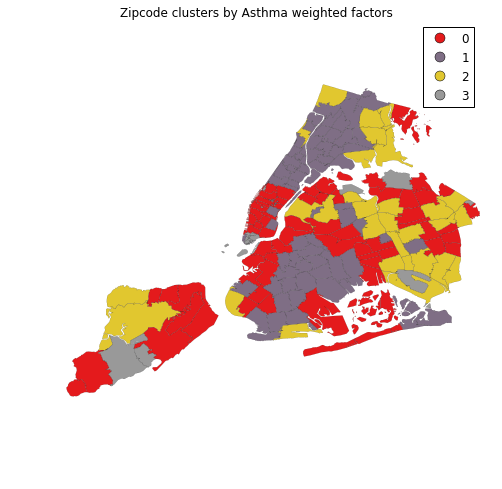

In [51]:
fig,ax = plt.subplots(figsize=(8,8))

ziphigh7.plot(column='labels', linewidth=0.1, 
             alpha=1, edgecolor = 'k', 
             ax=ax, legend = True, categorical = True)

ax.set_title('Zipcode clusters by Asthma weighted factors')
ax.set_axis_off()

## Discussion

the goal of this assignment is to find out and evaluate different factors that pre-assumed to be one of the predictors for asthma cases in NYC. From my analaysis, i used dataset for highway length and 311 calls, and the regression model on each of their effect on asthma cases are not strong, returning R-value about 0.1.

One of the reason for such poor result is the factor chosen in 311 complaint types that we believe to have a relation with asthma. Since it is based on personal knowledge, we cannot prove its confidentiality. Another reason could be the choice of datasets, some of the datasets may not come from the same year. 

## Extra Credit

In [52]:
alldischargeQuery = '''
SELECT facility_id, COUNT(*) as count
FROM nyc_discharge_2013
WHERE lower(ccs_diagnosis_description) LIKE '%asthma%'
GROUP BY facility_id
ORDER BY count DESC
'''

# SELECT facility_id, COUNT(*) AS count
# FROM nyc_discharge_2013
# WHERE lower(ccs_diagnosis_description) LIKE '%asthma%'
# GROUP BY facility_id
# ORDER BY count DESC
# LIMIT 5

# facilityStream = queryCartoDB(facilityQuery, format='GeoJSON')
# facilityData   = json.loads(facilityStream.read())
# facilities     = gpd.GeoDataFrame.from_features(facilityData['features'])

# zipcodeStream = queryCartoDB(zipcodeQuery, format='GeoJSON')
# zipcodeData   = json.loads(zipcodeStream.read())
# zipcodes      = gpd.GeoDataFrame.from_features(zipcodeData['features'])

In [53]:
allAsthmaStream = queryCartoDB(alldischargeQuery, format='CSV')
allAsthma = pd.read_csv(allAsthmaStream)

In [54]:
allFacilityQuery = '''
SELECT * 
FROM nyc_facilities
'''
allfacilityStream = queryCartoDB(allFacilityQuery, format='GeoJSON')
allfacilityData   = json.loads(allfacilityStream.read())
allFacilities    = gpd.GeoDataFrame.from_features(allfacilityData['features'])

In [55]:
allFacilities_Asthma = allFacilities.merge(allAsthma, how='left', on='facility_id')
allFacilities_Asthma.rename(columns = {'facility_zip_code':'zipcode'}, inplace=1)
allFacilities_Asthma.fillna(0)
allFacilities_Asthma.head()

,cartodb_id,cooperator_address,cooperator_address_2,cooperator_city,cooperator_name,cooperator_state,cooperator_zip_code,description,facility_address_1,facility_address_2,...,operator_address_2,operator_city,operator_name,operator_state,operator_zip_code,ownership_type,regional_office,regional_office_id,short_description,count
0,2106,,,,,New York,NaN,Diagnostic and Treatment Center,1110 Pennsylvania Avenue,,...,,Brooklyn,PALA Community Care LLC,New York,11207,LLC,Metropolitan Area Regional Office - New York City,5,DTC,NaN
1,2311,,,,,New York,NaN,Diagnostic and Treatment Center,468 Lafayette Avenue,,...,,Brooklyn,"Medcare, LLC",New York,11205,LLC,Metropolitan Area Regional Office - New York City,5,DTC,NaN
2,643,,,,,New York,NaN,Diagnostic and Treatment Center,1776 Clay Avenue,,...,,Bronx,P R O M E S A Inc,New York,10457,Not for Profit Corporation,Metropolitan Area Regional Office - New York City,5,DTC,NaN
3,805,,,,,New York,NaN,Residential Health Care Facility - SNF,214 West Houston Street,,...,,New York,Village Center for Care,New York,10271,Not for Profit Corporation,Metropolitan Area Regional Office - New York City,5,NH,NaN
4,1903,,,,,New York,NaN,Diagnostic and Treatment Center,2781 Third Ave,,...,,Bronx,Third Avenue Open MRI Inc,New York,10455,Business Corporation,Metropolitan Area Regional Office - New York City,5,DTC,NaN
